In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("check_particle_filter.ipynb")

# Particle filter 

This Jupyter notebook file imports (and tests) all of the code needed to do the particle filter assignment. Note that the actual code is in the .py files in this directory.

You should only have to edit particle_filter.py - you did all the "simulator" code in the previous two assignments.

Note that, although we use both sensors in this assignment, we'll only use one at a time, and update the particle distribution (importance sampling) before calling a calculate_weights method again.

Slides for this assignment: https://docs.google.com/presentation/d/1GVCAWUSUhJiHP6VBi-HusDyZmunQG1mnVlopLhtRGLs/edit?usp=sharing

In [2]:
import sys; sys.path.insert(0, '.')
import numpy as np
import matplotlib.pyplot as plt

# These commands will force JN to actually re-load the external file when you re-execute the import command
%load_ext autoreload
%autoreload 2

In [3]:
from particle_filter import ParticleFilter, test_particle_filter_syntax, test_doors, test_distance, test_reweighting
from world_ground_truth import WorldGroundTruth
from robot_sensors import RobotSensors
from robot_ground_truth import RobotGroundTruth

In [4]:
# Declare variables
n_doors = 2
n_bins = 10
n_samples = 100
world_ground_truth = WorldGroundTruth()
world_ground_truth.random_door_placement(n_doors, n_bins)
robot_ground_truth = RobotGroundTruth()
robot_sensor = RobotSensors()
particle_filter = ParticleFilter()

In [5]:
# Syntax check 1, reset probabilities
particle_filter.reset_particles(n_samples)

In [6]:
# Syntax check 2, update move
particle_filter.update_particles_move_continuous(robot_ground_truth, 0.1)

In [7]:
# Syntax checks 3 and 4 - the two different sensor readings
particle_filter.calculate_weights_door_sensor_reading(world_ground_truth, robot_sensor, True)
if np.isclose(np.max(particle_filter.weights), np.min(particle_filter.weights)):
    print(f"Possible error: The weights should not all be the same")

particle_filter.reset_particles(n_samples)
particle_filter.calculate_weights_distance_wall(robot_sensor, 0.1)
if np.isclose(np.max(particle_filter.weights), np.min(particle_filter.weights)):
    print(f"Possible error: The weights should not all be the same")

In [8]:
# Syntax check 5 - importance sampling
particle_filter.resample_particles()
if not np.isclose(np.max(particle_filter.weights), np.min(particle_filter.weights)):
    print(f"Possible error: The weights should be set back to all the same")
if np.unique(particle_filter.particles, return_counts=True) == n_samples:
    print(f"Possible error: There probably should be duplicate particles {np.unique(particle_filter.particles, return_counts=True)} {n_samples}")

In [9]:
# Syntax checks 6 and 7 - the two full updates
particle_filter.one_full_update_door(world_ground_truth, robot_ground_truth, robot_sensor, u=0.1, z=True)
particle_filter.one_full_update_distance(robot_ground_truth, robot_sensor, u=0.1, z=0.6)

In [10]:
test_particle_filter_syntax(b_print=True)

Testing particle filter (syntax)
Should be approximately equal, seq: ['Door']
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
Your h: [0.045 0.046 0.043 0.069 0.066 0.023 0.048 0.035 0.061 0.076 0.071 0.011
 0.053 0.076 0.014 0.043 0.058 0.033 0.065 0.064]
Approximate h: [0.045 0.046 0.043 0.069 0.066 0.023 0.048 0.035 0.061 0.076 0.071 0.011
 0.053 0.076 0.014 0.043 0.058 0.033 0.065 0.064]

Should be approximately equal, seq: ['Dist']
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
Your h: [0.    0.    0.    0.001 0.003 0.012 0.033 0.046 0.109 0.172 0.224 0.168
 0.137 0.055 0.031 0.007 0.002 0.    0.    0.   ]
Approximate h: [0.    0.    0.    0.001 0.003 0.012 0.033 0.046 0.109 0.172 0.224 0.168
 0.137 0.055 0.031 0.007 0.002 0.    0.    0.   ]

Should be approximately equal, seq: ['Move']
[ True False False False False  True False  Tr

True

In [11]:
grader.check("syntax_check")

syntax_check results: All test cases passed!

## Door sensor
Did you calculate the door sensor correctly?

Tall particles in door if sensor is True, otherwise, short particles in doors.

Testing particle filter (doors)
Passed get_number_of_particles check
Passed: All particle values for particles in front of door should be the same
Passed: All particle values for particles NOT in front of door should be the same
Passed test_door {test_door}
Passed get_number_of_particles check
Passed: All particle values for particles in front of door should be the same
Passed: All particle values for particles NOT in front of door should be the same
Passed test_door {test_door}


True

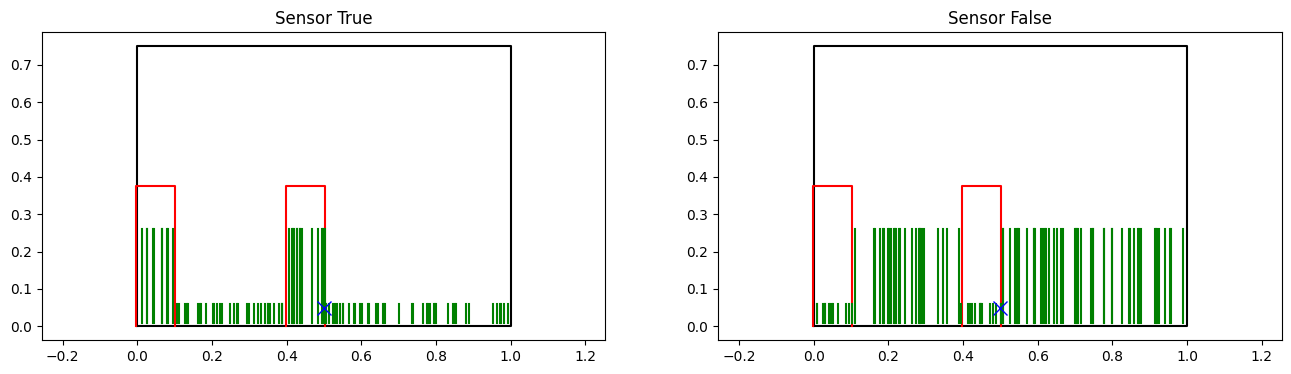

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

n_doors = 2
n_bins = 10
n_particles = 100
np.random.seed(2)

# Initialize with values that are NOT the default ones
world_ground_truth.random_door_placement(n_doors, n_bins)

# Two cases - sensor returned True or False
axs[0].set_title("Sensor True")
particle_filter.reset_particles(n_particles)
particle_filter.calculate_weights_door_sensor_reading(world_ground_truth, robot_sensor, True)
particle_filter.plot_particles_with_weights(axs[0], world_ground_truth, robot_ground_truth)
axs[0].axis('equal')

axs[1].set_title("Sensor False")
particle_filter.reset_particles(n_particles)
particle_filter.calculate_weights_door_sensor_reading(world_ground_truth, robot_sensor, False)
particle_filter.plot_particles_with_weights(axs[1], world_ground_truth, robot_ground_truth)
axs[1].axis('equal')

# Check figure (see slides)
test_doors(b_print=True)

In [13]:
grader.check("draw_door")

draw_door results: All test cases passed!

## Distance sensor - is your distance sensor setting correct values?
Should show a Gaussian centered at the distance input

(-0.052362500000000006, 1.0501125, -0.037500000000000006, 0.7875)

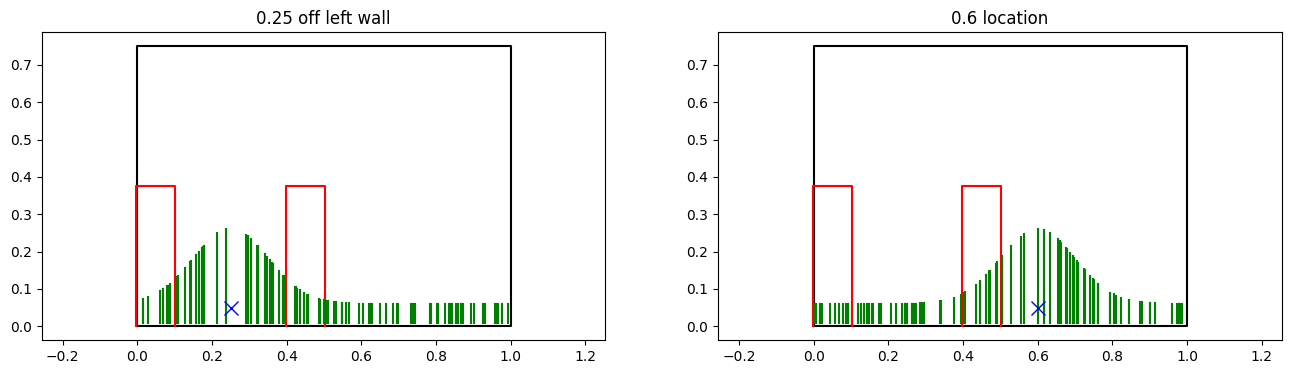

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

# Two cases - sensor returned 0.25 or 0.6
axs[0].set_title("0.25 off left wall")
robot_ground_truth.robot_loc = 0.25
particle_filter.reset_particles(n_particles)
particle_filter.calculate_weights_distance_wall(robot_sensor, 0.25)
particle_filter.plot_particles_with_weights(axs[0], world_ground_truth, robot_ground_truth)
axs[0].axis('equal')

axs[1].set_title("0.6 location")
robot_ground_truth.robot_loc = 0.6
particle_filter.reset_particles(n_particles)
particle_filter.calculate_weights_distance_wall(robot_sensor, 0.6)
particle_filter.plot_particles_with_weights(axs[1], world_ground_truth, robot_ground_truth)
axs[1].axis('equal')

In [15]:
grader.check("draw_distance")

draw_distance results: All test cases passed!

## Importance weighting/resampling
Do you resample the particles correctly? More particles in "bump"

Testing particle filter (reweighting)
Passed test: All particles have equal weight
Passed test: most particles close to robot loc after distance sensor read


True

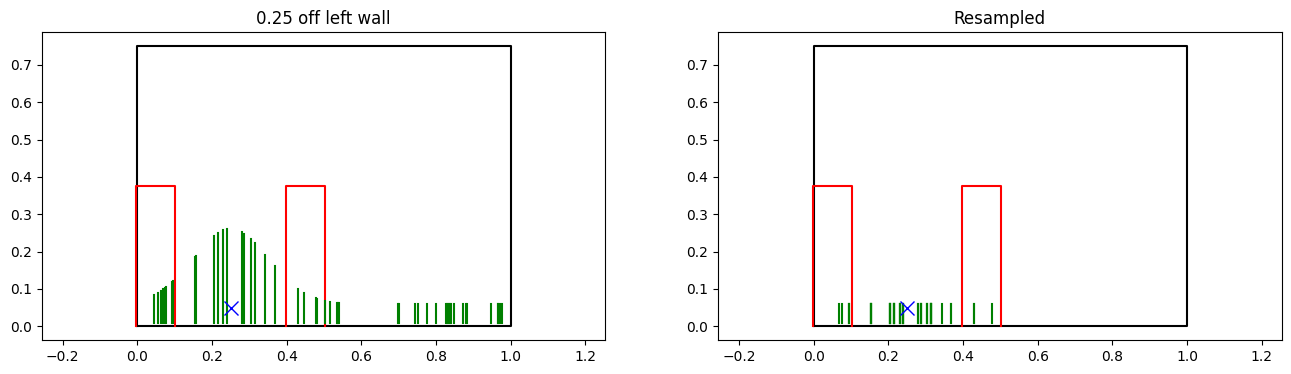

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

n_particles = 50
# Sensor reading first, to calculate weights
axs[0].set_title("0.25 off left wall")
robot_ground_truth.robot_loc = 0.25
particle_filter.reset_particles(n_particles)
particle_filter.calculate_weights_distance_wall(robot_sensor, 0.25)
particle_filter.plot_particles_with_weights(axs[0], world_ground_truth, robot_ground_truth)
axs[0].axis('equal')

# Now resample
axs[1].set_title("Resampled")
particle_filter.resample_particles()
particle_filter.plot_particles_with_weights(axs[1], world_ground_truth, robot_ground_truth)
axs[1].axis('equal')

test_reweighting(True)

In [17]:
grader.check("resample")

resample results: All test cases passed!

<!-- BEGIN QUESTION -->

## Robot moves
Do the particles shift? All should pile up on the left (or right) side, depending on the move direction.
Also should spread out over time

(-0.052362500000000006, 1.0501125, -0.037500000000000006, 0.7875)

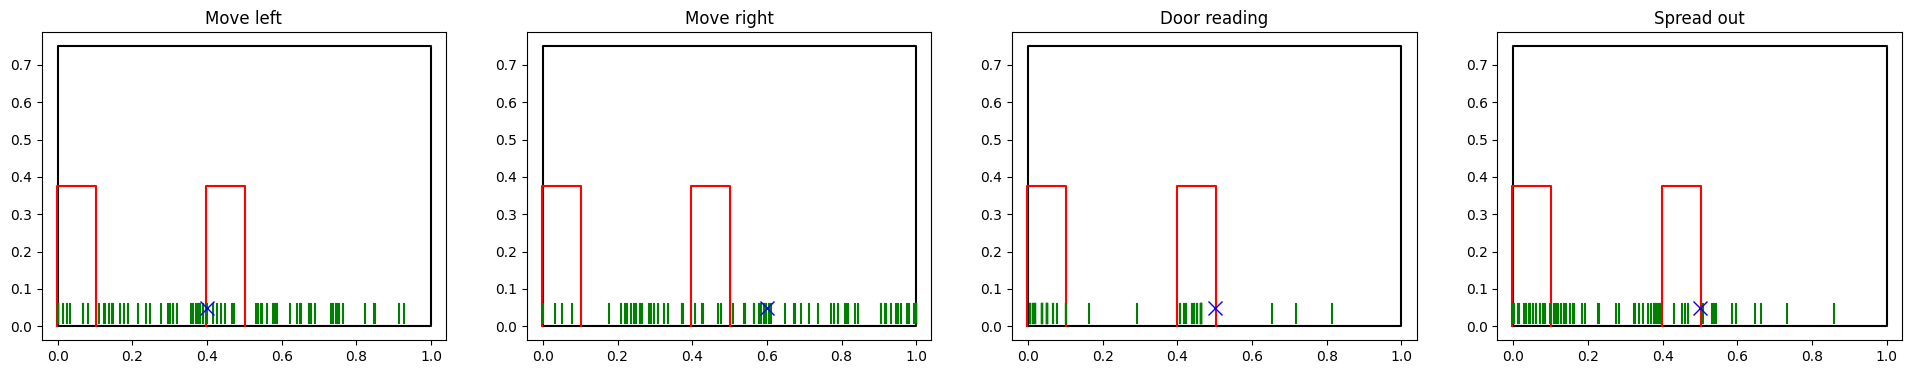

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(24, 4))

n_particles = 75

# Move to the left
axs[0].set_title("Move left")
robot_ground_truth.robot_loc = 0.4
particle_filter.reset_particles(n_particles)
particle_filter.update_particles_move_continuous(robot_ground_truth, -0.1)
particle_filter.plot_particles_with_weights(axs[0], world_ground_truth, robot_ground_truth)
axs[0].axis('equal')

axs[1].set_title("Move right")
robot_ground_truth.robot_loc = 0.6
particle_filter.reset_particles(n_particles)
particle_filter.update_particles_move_continuous(robot_ground_truth, 0.1)
particle_filter.plot_particles_with_weights(axs[1], world_ground_truth, robot_ground_truth)
axs[1].axis('equal')

axs[2].set_title("Door reading")
robot_ground_truth.robot_loc = 0.5
particle_filter.reset_particles(n_particles)
# Pile up particles in front of doors
for _ in range(0, 2):
    particle_filter.calculate_weights_door_sensor_reading(world_ground_truth, robot_sensor, True)
    particle_filter.resample_particles()
particle_filter.plot_particles_with_weights(axs[2], world_ground_truth, robot_ground_truth)
axs[2].axis('equal')

# "Don't" move for 2 iterations - but should still spread particles out
axs[3].set_title("Spread out")
for _ in range(0, 2):
    particle_filter.update_particles_move_continuous(robot_ground_truth, 0.0)
    
particle_filter.plot_particles_with_weights(axs[3], world_ground_truth, robot_ground_truth)
axs[3].axis('equal')


<!-- END QUESTION -->

## Do one full loop
Do a move, sensor loop a few times

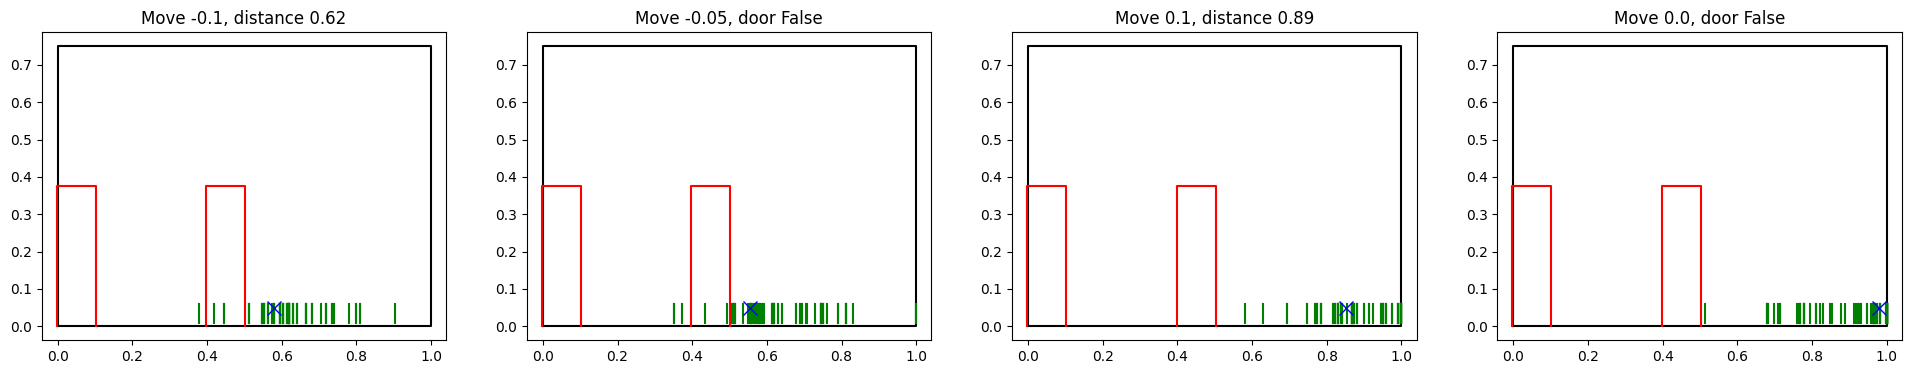

In [19]:
fig, axs = plt.subplots(1, 4, figsize=(24, 4))

n_particles = 75

# Moves followed by door, then distance, then door, then distance reading
moves = [-0.1, -0.05, 0.1, 0.0]

particle_filter.reset_particles(n_particles)
robot_ground_truth.robot_loc = 0.5

np.random.seed(3)

for i, u in enumerate(moves):
    robot_ground_truth.move_continuous(u)
    if i % 2:
        saw_door = robot_sensor.query_door(robot_ground_truth, world_ground_truth)
        particle_filter.one_full_update_door(world_ground_truth, robot_ground_truth, robot_sensor, u, saw_door)
        axs[i].set_title(f"Move {u}, door {saw_door}")
    else:
        dist = robot_sensor.query_distance_to_wall(robot_ground_truth)
        particle_filter.one_full_update_distance(robot_ground_truth, robot_sensor, u, dist)
        axs[i].set_title(f"Move {u}, distance {dist:0.2f}")
    
    axs[i].axis('equal')
    particle_filter.plot_particles_with_weights(axs[i], world_ground_truth, robot_ground_truth)


## Hours and collaborators
Required for every assignment - fill out before you hand-in.

Listing names and websites helps you to document who you worked with and what internet help you received in the case of any plagiarism issues. You should list names of anyone (in class or not) who has substantially helped you with an assignment - or anyone you have *helped*. You do not need to list TAs.

Listing hours helps us track if the assignments are too long.

In [ ]:

# List of names (creates a set)
worked_with_names = {"self"}
# List of URLS FW25(creates a set)
websites = {"class slides notes, https://amrl.cs.utexas.edu/interactive-particle-filters/, and ChatGPT for debugging and examples"}
# Approximate number of hours, including lab/in-class time
hours = 14

In [21]:
grader.check("hours_collaborators")

hours_collaborators results: All test cases passed!

### To submit

- Do a restart then run all to make sure everything runs ok
- Save the file
- Submit this .ipynb file and **robot_sensors.py** and **robot_ground_truth.py** and **particle_filter.py** through gradescope, Homework Particle filter
- You do NOT need to submit the data files - we will supply those
- Take out/suppress all print statements that are not part of the tests

If the Gradescope autograder fails, please check here first for common reasons for it to fail
    https://docs.google.com/presentation/d/1tYa5oycUiG4YhXUq5vHvPOpWJ4k_xUPp2rUNIL7Q9RI/edit?usp=sharing

Most likely failure for this assignment is not naming the data directory and files correctly; capitalization matters for the Gradescope grader. 

Second reason for failure is you forgot to include the **.py** files and/or you put the file(s) in a folder

Sometimes it's just that the random numbers don't quite work out; if it seems like that's the case, add a note below
